In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
import time

from helper_functions import read_field_data, calculate_E_field, grid_from_header, calculate_pseudopotential, construct_interp_funcs, sample_and_solve_trajectories

# Read data from ANSYS exported files
Notes:
1. ANSYS exported RF file contains magnitude of electric field in space.
2. ANSYS exported DC file contains electric potential in space.
3. DC files are divided into different zones (labelled as 'gl', 'cy', 'c1', 'c2', 'c3') to reduce inaccuracy near trapping area.
4. RF field is only considered inside rf_range, zero RF field will be returned when outside

In [3]:
# Set up zoning configuration
U2 = -0.5
Ext_pulse = 20
Mesh = 250
MCP = 300
prefix = f'U{-U2}E{Ext_pulse}M{Mesh}M{MCP}'

dc_conf = {
    'gl': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_global.fld'},
    'cy': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cylinder.fld'},
    'c1': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube1.fld'},
    'c2': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube2.fld'},
    'c3': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube3.fld'}
        }
rf_file = '..\\Ansys\\Outputs_RF\\TrajSimTest_Cube3.fld'
rf_range = {'min': (-3e-4, -3e-4, -3e-4), 'max': (3e-4, 3e-4, 3e-4)}

In [4]:
# Read data from files and organize them (takes less than 1 minute)
dc_conf, grid, voltage, rf_grid, magE = read_field_data(dc_conf, rf_file)

Reading zone gl
File Readout Time: 6.7336 seconds.
Reading zone cy
File Readout Time: 31.0779 seconds.
Reading zone c1
File Readout Time: 10.9517 seconds.
Reading zone c2
File Readout Time: 14.8928 seconds.
Reading zone c3
File Readout Time: 14.9926 seconds.
Reading RF data...
RF File Readout Time: 14.5910 seconds.


# Process ANSYS data and construct interpolation
This step includes:
1. Calculate RF pseudopotential from ANSYS RF file from equation: $U_{ps}=\dfrac{q^2|E|^2}{4m\Omega^2}$Note that $\Omega=2\pi f$.
2. Take gradient of RF and DC field to get equivalent electric fields: $\vec{E}_{dc}=-\nabla V_{dc}$ and $\vec{E}_{eq,rf}=\dfrac{1}{e}\nabla U_{ps}$.
3. Calculate interpolation function for RF and DC fields so that we can handle non grid points (fill NaNs in data if needed).

In [6]:
# Calcuate DC and RF fields
dc_field = calculate_E_field(dc_conf, voltage)

freq = 1.36e+09
_, _, step = grid_from_header(filename=rf_file, mode='conf')
Ups, rf_force = calculate_pseudopotential(magE, freq, gradient=True, stepsize=step[0])

In [7]:
# Construct Interpolations
# Time consuming, takes ~ 4 minutes to fill NaNs, ~ 12 minutes to build interpolations
dc_interps, rf_interp = construct_interp_funcs(dc_field, grid, data_rf=rf_force, grid_rf=rf_grid, fill_NaNs=True)

Filling NaNs in data for zone gl ...
Time consumed for filling NaNs in x component: 16.2767 seconds.
Time consumed for filling NaNs in y component: 16.2698 seconds.
Time consumed for filling NaNs in z component: 16.2514 seconds.
Filling NaNs in data for zone cy ...
Time consumed for filling NaNs in x component: 53.7184 seconds.
Time consumed for filling NaNs in y component: 52.8471 seconds.
Time consumed for filling NaNs in z component: 54.4982 seconds.
Filling NaNs in data for zone c1 ...
Time consumed for filling NaNs in x component: 16.7746 seconds.
Time consumed for filling NaNs in y component: 16.6033 seconds.
Time consumed for filling NaNs in z component: 16.7580 seconds.
Filling NaNs in data for zone c2 ...
Time consumed for filling NaNs in x component: 22.6571 seconds.
Time consumed for filling NaNs in y component: 22.4281 seconds.
Time consumed for filling NaNs in z component: 22.5217 seconds.
Filling NaNs in data for zone c3 ...
Time consumed for filling NaNs in x component: 

In [8]:
# Delete unneeded params to free RAM space
import gc

del grid, voltage, rf_grid, magE, dc_field, Ups, rf_force
gc.collect()

0

# Solve trajectories of electrons when extraction pulse was applied
Note:
1. The equation of motion of the electrons is $m_e\vec{a}=-e(\vec{E}_{dc}+\vec{E}_{eq,rf})$.
2. When an electron travels outside the interpolation zone [-8, 8] x [-8, 8] x [-1, 21] (unit: mm), simulation will be terminated.
3. Time for electrons arriving at the MCP ([-5, 5] x [-5, 5], {z=20}, unit: mm) from bottom to top (z increase) was recorded.
4. Codes are wrapped in helper_functions.sample_and_solve_trajectories

In [10]:
# Set simulation configurations
num_particles = 10000
num_trajectories = 500
sigma_pos = 200e-6
sigma_velo = 6e+4

# Trajectories are large so we only save a couple of them for efficiency
# Can take ~ 1 hour
results = sample_and_solve_trajectories(num_particles, sigma_pos, sigma_velo, dc_interps, rf_interp, dc_conf, rf_range, save_trajectories=False)
trajs = sample_and_solve_trajectories(num_trajectories, sigma_pos, sigma_velo, dc_interps, rf_interp, dc_conf, rf_range, save_trajectories=True)

Generating initial conditions for particles ...
Simulating particle trajectories ...
Solving particles 10000/10000 ...
Time consumed for calculating 10000 trajectories: 4681.2049 seconds.
Generating initial conditions for particles ...
Simulating particle trajectories ...
Solving particles 500/500 ...
Time consumed for calculating 500 trajectories: 231.8229 seconds.


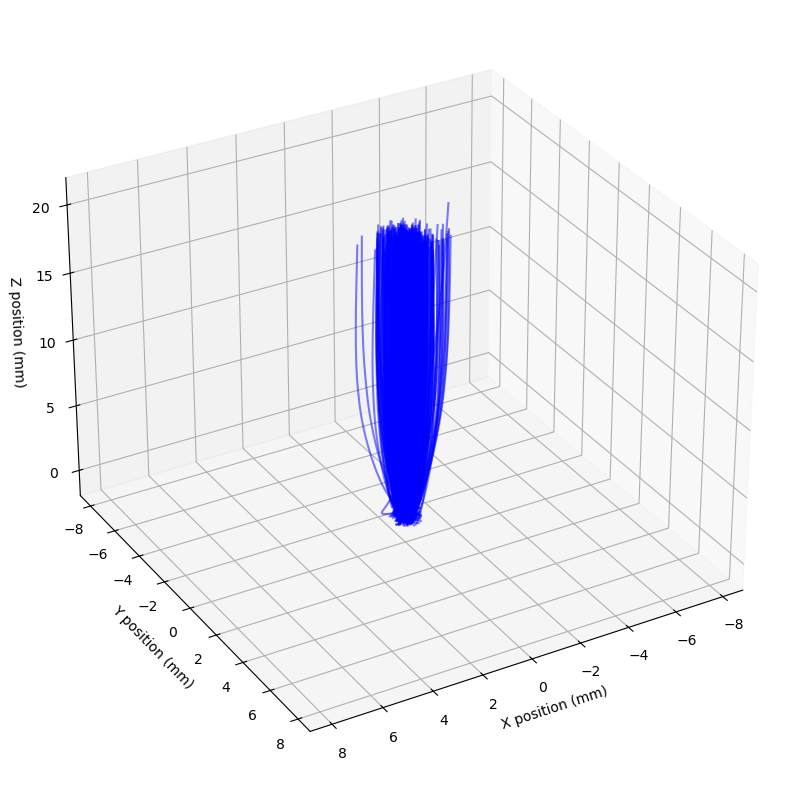

In [11]:
# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Set the axes labels
ax.set_xlabel('X position (mm)')
ax.set_ylabel('Y position (mm)')
ax.set_zlabel('Z position (mm)')

# Set the axes limits according to the specified space
ax.set_xlim(-8.5, 8.5)
ax.set_ylim(-8.5, 8.5)
ax.set_zlim(-1.5, 21.5)

# Add a grid
ax.grid(True)

for instance in trajs['trajectories']:
    
    x_traj = instance['y'][0] * 1e+03
    y_traj = instance['y'][1] * 1e+03
    z_traj = instance['y'][2] * 1e+03
    
    ax.plot(x_traj, y_traj, z_traj, color='b', alpha=0.5)

# Optionally, adjust the viewing angle
ax.view_init(elev=30, azim=60)

# Show the plot
plt.tight_layout()
plt.show()

# Analyze the electron trajectories by doing statistics

9994 out of 10000 particles left the region in 10 nanoseconds.
Average time for these particles to leave the region is 4.273967071637704 nanoseconds.


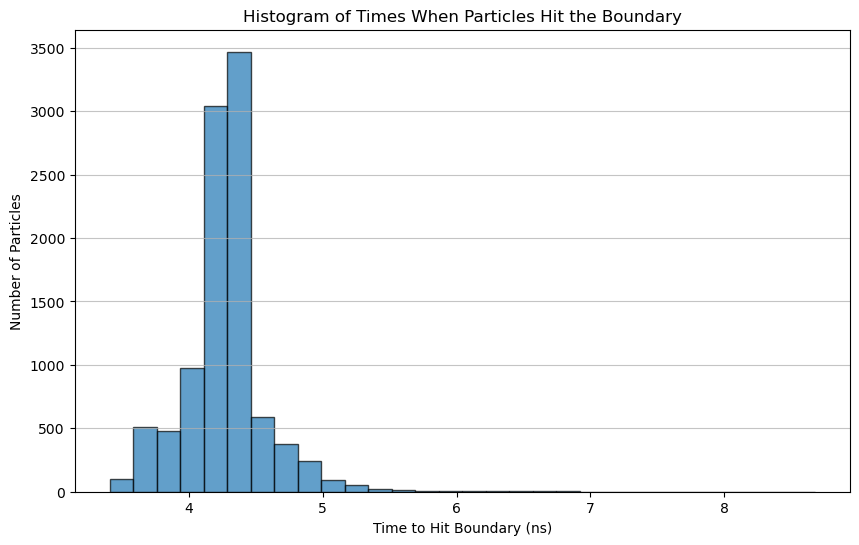

In [13]:
# Extract the t_boundary list
t_boundary = results['t_boundary']

# Filter out None values (particles that did not hit the boundary)
t_boundary_filtered = [t for t in t_boundary if t is not None]
print(f'{len(t_boundary_filtered)} out of {num_particles} particles left the region in 10 nanoseconds.')
print(f'Average time for these particles to leave the region is {np.mean(t_boundary_filtered)*1e9} nanoseconds.')

# Check if there are any boundary hits
if len(t_boundary_filtered) == 0:
    print("No particles hit the boundary.")
else:
    # Convert times to nanoseconds for better readability
    t_boundary_ns = np.array(t_boundary_filtered) * 1e9  # Convert from seconds to nanoseconds

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(t_boundary_ns, bins=30, edgecolor='black', alpha=0.7)

    # Set labels and title
    plt.xlabel('Time to Hit Boundary (ns)')
    plt.ylabel('Number of Particles')
    plt.title('Histogram of Times When Particles Hit the Boundary')

    # Show grid lines for better readability
    plt.grid(axis='y', alpha=0.75)

    # Display the plot
    plt.show()

9993 out of 10000 particles hit the MCP.
Average time for these particles to leave the region is 4.175484635238173 nanoseconds.


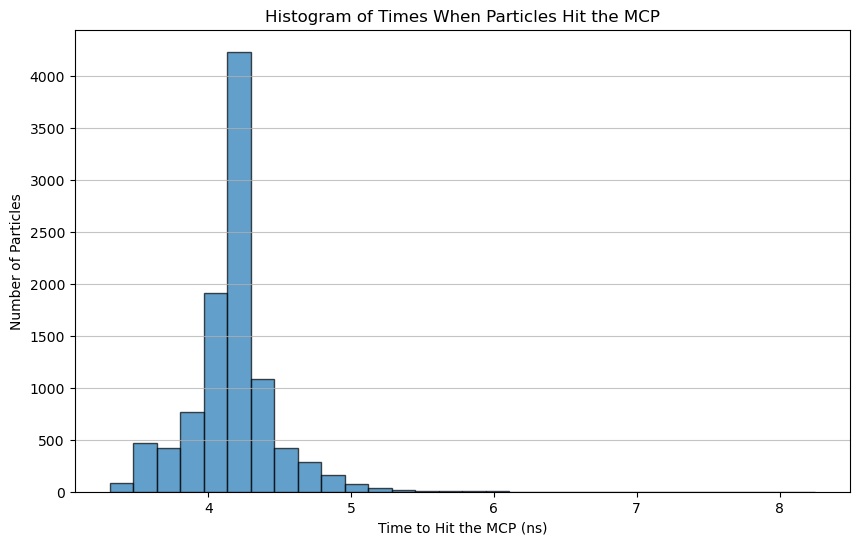

In [14]:
# Extract the t_mcp list
t_mcp = results['t_mcp']
n_mcp = results['num_hit_mcp']

# Filter out None values (particles that did not hit the boundary)
t_mcp_filtered = [t for t in t_mcp if t is not None]
print(f'{n_mcp} out of {num_particles} particles hit the MCP.')
print(f'Average time for these particles to leave the region is {np.mean(t_mcp_filtered)*1e9} nanoseconds.')

# Check if there are any boundary hits
if len(t_mcp_filtered) == 0:
    print("No particles hit the MCP.")
else:
    # Convert times to nanoseconds for better readability
    t_mcp_ns = np.array(t_mcp_filtered) * 1e9  # Convert from seconds to nanoseconds

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(t_mcp_ns, bins=30, edgecolor='black', alpha=0.7)

    # Set labels and title
    plt.xlabel('Time to Hit the MCP (ns)')
    plt.ylabel('Number of Particles')
    plt.title('Histogram of Times When Particles Hit the MCP')

    # Show grid lines for better readability
    plt.grid(axis='y', alpha=0.75)

    # Display the plot
    plt.show()

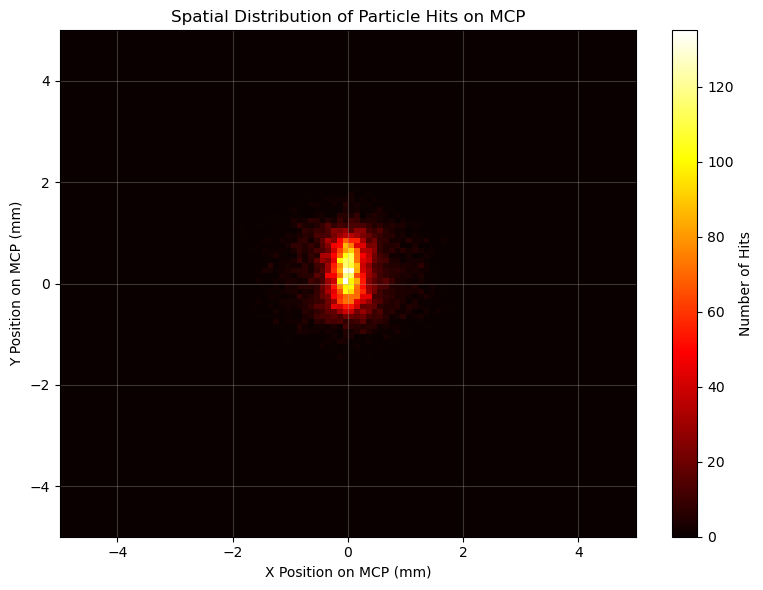

In [15]:
# Extract the state_at_mcp list
state_at_mcp = results['state_at_mcp']

# Filter out None values (particles that did not hit the MCP)
states_mcp_filtered = [state for state in state_at_mcp if state is not None]

# Check if any particles hit the MCP
if len(states_mcp_filtered) == 0:
    print("No particles hit the MCP.")
else:
    # Extract x and y positions from the state vectors
    positions_mcp = np.array([[state[0], state[1]] for state in states_mcp_filtered])  # Positions in meters

    # Convert positions to millimeters
    positions_mcp_mm = positions_mcp * 1e3  # Convert from meters to millimeters

    # Separate x and y coordinates
    x_mcp = positions_mcp_mm[:, 0]
    y_mcp = positions_mcp_mm[:, 1]

    # Define the MCP area boundaries (in millimeters)
    x_min, x_max = -5.0, 5.0  # MCP x-range from -5 mm to 5 mm
    y_min, y_max = -5.0, 5.0  # MCP y-range from -5 mm to 5 mm

    # Define the number of bins for the histogram
    num_bins = 100  # Adjust as needed for resolution

    # Create a 2D histogram of the hit positions
    heatmap, xedges, yedges = np.histogram2d(x_mcp, y_mcp, bins=num_bins, range=[[x_min, x_max], [y_min, y_max]])

    # Plot the 2D histogram as a heatmap
    plt.figure(figsize=(8, 6))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', interpolation='nearest', aspect='auto')

    # Add colorbar to indicate density scale
    cbar = plt.colorbar()
    cbar.set_label('Number of Hits')

    # Set labels and title
    plt.xlabel('X Position on MCP (mm)')
    plt.ylabel('Y Position on MCP (mm)')
    plt.title('Spatial Distribution of Particle Hits on MCP')

    # Optionally, add contour lines for better visualization
    # plt.contour(heatmap.T, extent=extent, origin='lower', colors='white', linewidths=0.5)

    # Show grid lines
    plt.grid(alpha=0.3)

    # Set limits to match the MCP area
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Display the plot
    plt.tight_layout()
    plt.show()